##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Matrix approximation with Core APIs

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/core/matrix_core"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/core/matrix_core.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/core/matrix_core.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/core/matrix_core.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Introduction 

This notebook uses the [TensorFlow Core low-level APIs](https://www.tensorflow.org/guide/core) to showcase TensorFlow's capabilities as a high-performance scientific computing platform. Visit the [Core APIs overview](https://www.tensorflow.org/guide/core) to learn more about TensorFlow Core and its intended use cases.

This tutorial explores the technique of [singular value decomposition](https://developers.google.com/machine-learning/recommendation/collaborative/matrix) (SVD) and its applications for low-rank approximation problems. The SVD is used to factorize real or complex matrices and has a variety of use cases in data science such as image compression. The images for this tutorial come from Google Brain's [Imagen](https://imagen.research.google/) project. 

>![svd_intro](http://tensorflow.org/images/core/svd_intro.png)

## Setup

In [2]:
import matplotlib
from matplotlib.image import imread
from matplotlib import pyplot as plt
import requests
# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [16, 9]

In [3]:
import tensorflow as tf
print(tf.__version__)

2024-08-15 02:40:31.007111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 02:40:31.028202: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 02:40:31.034794: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.17.0


## SVD fundamentals

The singular value decomposition of a matrix, ${\mathrm{A}}$, is determined by the following factorization:

$${\mathrm{A}} = {\mathrm{U}} \Sigma {\mathrm{V}}^T$$

where

* $\underset{m \times n}{\mathrm{A}}$: input matrix where $m \geq n$
* $\underset{m \times n}{\mathrm{U}}$: orthogonal matrix, ${\mathrm{U}}^T{\mathrm{U}} = {\mathrm{I}}$, with each column, $u_i$, denoting a left singular vector of ${\mathrm{A}}$
* $\underset{n \times n}{\Sigma}$: diagonal matrix with each diagonal entry, $\sigma_i$, denoting a singular value of ${\mathrm{A}}$
* $\underset{n \times n}{{\mathrm{V}}^T}$: orthogonal matrix, ${\mathrm{V}}^T{\mathrm{V}} = {\mathrm{I}}$, with each row, $v_i$, denoting a right singular vector of ${\mathrm{A}}$

When $m < n$, ${\mathrm{U}}$ and $\Sigma$ both have dimension $(m \times m)$, and ${\mathrm{V}}^T$ has dimension $(m \times n)$.

>![svd_full](http://tensorflow.org/images/core/svd_full.png)

TensorFlow's linear algebra package has a function, `tf.linalg.svd`, which can be used to compute the singular value decomposition of one or more matrices. Start by defining a simple matrix and computing its SVD factorization.


I0000 00:00:1723689633.424919  126589 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723689633.428762  126589 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723689633.432420  126589 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723689633.437707  126589 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

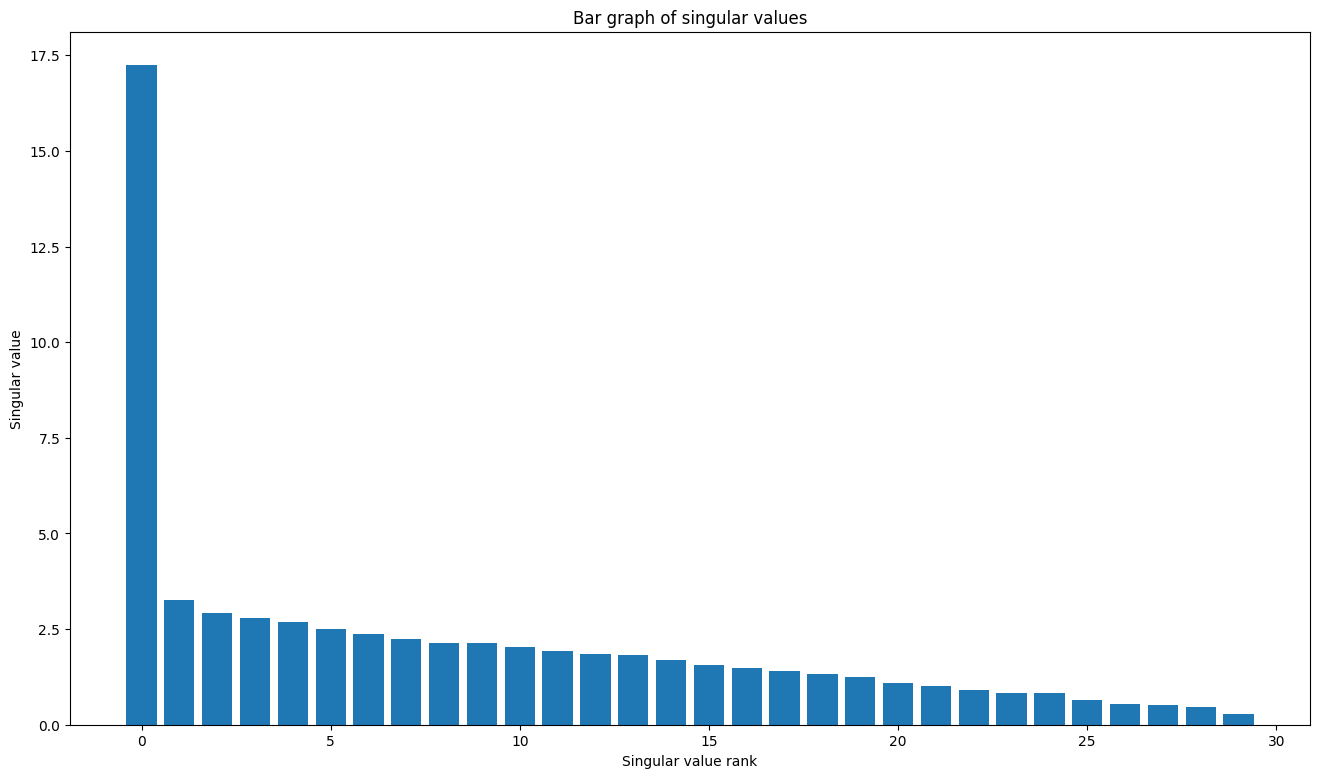

In [4]:
A = tf.random.uniform(shape=[40,30])
# Compute the SVD factorization
s, U, V = tf.linalg.svd(A)
# Define Sigma and V Transpose
S = tf.linalg.diag(s)
V_T = tf.transpose(V)
# Reconstruct the original matrix
A_svd = U@S@V_T
# Visualize 
plt.bar(range(len(s)), s);
plt.xlabel("Singular value rank")
plt.ylabel("Singular value")
plt.title("Bar graph of singular values");

The `tf.einsum` function can be used to directly compute the matrix reconstruction from the outputs of `tf.linalg.svd`.

In [5]:
A_svd = tf.einsum('s,us,vs -> uv',s,U,V)
print('\nReconstructed Matrix, A_svd', A_svd)


Reconstructed Matrix, A_svd tf.Tensor(
[[0.819255   0.95082176 0.30085772 ... 0.34306473 0.9112067  0.45277762]
 [0.71988434 0.20786765 0.3098724  ... 0.82478774 0.82917416 0.19994356]
 [0.23278469 0.17072585 0.10488278 ... 0.60508984 0.8121238  0.10594818]
 ...
 [0.10953172 0.72077066 0.30288345 ... 0.5790409  0.15389094 0.11265922]
 [0.44894537 0.04313891 0.6947845  ... 0.41589245 0.6668094  0.53494996]
 [0.79140556 0.47814542 0.24980234 ... 0.32851136 0.86007696 0.32692394]], shape=(40, 30), dtype=float32)


## Low rank approximation with the SVD

The rank of a  matrix, ${\mathrm{A}}$, is determined by the dimension of the vector space spanned by its columns. 
The SVD can be used to approximate a matrix with a lower rank, which ultimately decreases the dimensionality of data required to store the information represented by the matrix.

The rank-r approximation of ${\mathrm{A}}$ in terms of the SVD is defined by the formula:

$${\mathrm{A_r}} = {\mathrm{U_r}} \Sigma_r {\mathrm{V_r}}^T$$

where

* $\underset{m \times r}{\mathrm{U_r}}$: matrix consisting of the first $r$ columns of ${\mathrm{U}}$
* $\underset{r \times r}{\Sigma_r}$:  diagonal matrix consisting of the first  $r$ singular values in $\Sigma$
* $\underset{r \times n}{\mathrm{V_r}}^T$: matrix consisting of the first $r$ rows of ${\mathrm{V}}^T$

>![svd_approx](http://tensorflow.org/images/core/svd_approx.png)

Start by writing a function to compute the rank-r approximation of a given matrix. This low-rank approximation procedure is used for image compression; therefore, it is also helpful to compute the physical data sizes for each approximation. For simplicity, assume that data size for an rank-r approximated matrix is equal to the total number of elements required to compute the approximation. Next, write a function to visualize the original matrix, $\mathrm{A}$ its rank-r approximation, $\mathrm{A}_r$ and the error matrix, $|\mathrm{A} - \mathrm{A}_r|$.

In [6]:
def rank_r_approx(s, U, V, r, verbose=False):
  # Compute the matrices necessary for a rank-r approximation
  s_r, U_r, V_r = s[..., :r], U[..., :, :r], V[..., :, :r] # ... implies any number of extra batch axes
  # Compute the low-rank approximation and its size
  A_r = tf.einsum('...s,...us,...vs->...uv',s_r,U_r,V_r)
  A_r_size = tf.size(U_r) + tf.size(s_r) + tf.size(V_r)
  if verbose:
    print(f"Approximation Size: {A_r_size}")
  return A_r, A_r_size

def viz_approx(A, A_r):
  # Plot A, A_r, and A - A_r
  vmin, vmax = 0, tf.reduce_max(A)
  fig, ax = plt.subplots(1,3)
  mats = [A, A_r, abs(A - A_r)]
  titles = ['Original A', 'Approximated A_r', 'Error |A - A_r|']
  for i, (mat, title) in enumerate(zip(mats, titles)):
    ax[i].pcolormesh(mat, vmin=vmin, vmax=vmax)
    ax[i].set_title(title)
    ax[i].axis('off')

In [7]:
print(f"Original Size of A: {tf.size(A)}")
s, U, V = tf.linalg.svd(A)

Original Size of A: 1200


Approximation Size: 1065


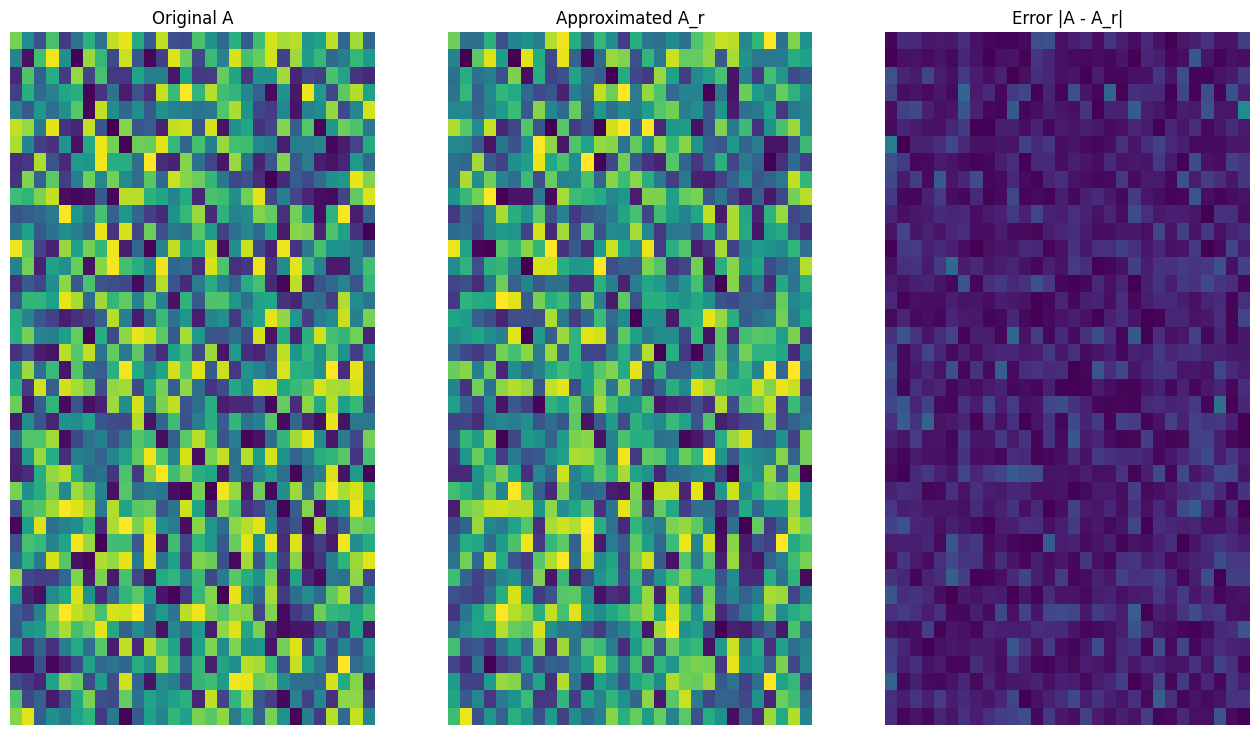

In [8]:
# Rank-15 approximation
A_15, A_15_size = rank_r_approx(s, U, V, 15, verbose = True)
viz_approx(A, A_15)

Approximation Size: 213


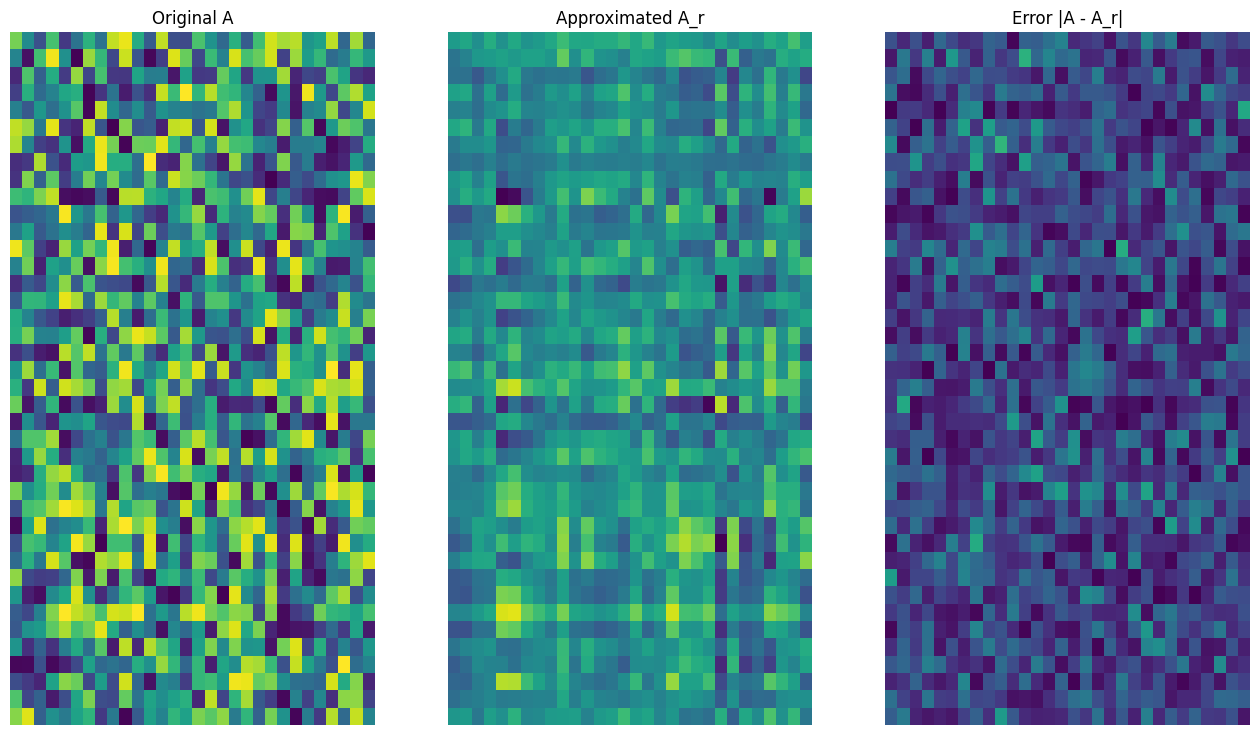

In [9]:
# Rank-3 approximation
A_3, A_3_size = rank_r_approx(s, U, V, 3, verbose = True)
viz_approx(A, A_3)

As expected, using lower ranks results in less-accurate approximations. However, the quality of these low-rank approximations are often good enough in real world scenarios. Also note that the main goal of low-rank approximation with SVD 
is to reduce the dimensionality of the data but not to reduce the disk space of the data itself. However, as the input matrices become higher-dimensional, many low-rank approximations also end up benefiting from reduced data size. This reduction benefit is why the process is applicable for image compression problems.

## Image loading

The following image is available on the [Imagen](https://imagen.research.google/) home page. Imagen is a text-to-image diffusion model developed by Google Research's Brain team. An AI created this image based on the prompt: "A photo of a Corgi dog riding a bike in Times Square. It is wearing sunglasses and a beach hat." How cool is that! You can also change the url below to any .jpg link to load in a custom image of choice. 

Start by reading in and visualizing the image. After reading a JPEG file, Matplotlib outputs a matrix, ${\mathrm{I}}$, of shape $(m \times n \times 3)$ which represents a 2-dimensional image with 3 color channels for red, green and blue respectively.

In [10]:
img_link = "https://imagen.research.google/main_gallery_images/a-photo-of-a-corgi-dog-riding-a-bike-in-times-square.jpg"
img_path = requests.get(img_link, stream=True).raw
I = imread(img_path, 0)
print("Input Image Shape:", I.shape)

Input Image Shape: (1024, 1024, 3)


In [11]:
def show_img(I):
  # Display the image in matplotlib
  img = plt.imshow(I)
  plt.axis('off')
  return

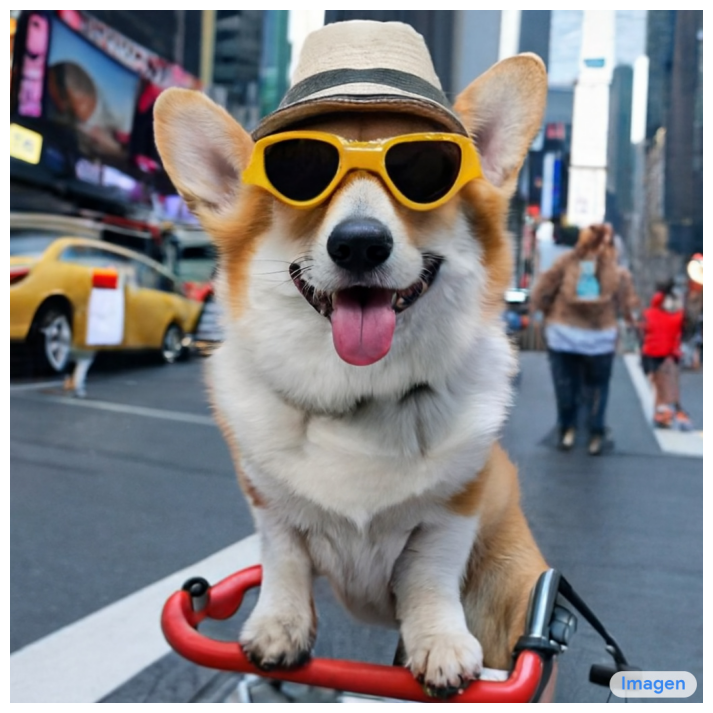

In [12]:
show_img(I)

## The image compression algorithm

Now, use the SVD to compute low-rank approximations of the sample image. Recall that the image is of shape $(1024 \times 1024 \times 3)$ and that the theory SVD only applies for 2-dimensional matrices. This means that the sample image has to be batched into 3 equal-size matrices that correspond to each of the 3 color channels. This can be done so by transposing the matrix to be of shape $(3 \times 1024 \times 1024)$. In order to clearly visualize the approximation error, rescale the RGB values of the image from $[0,255]$ to $[0,1]$. Remember to clip the approximated values to fall within this interval before visualizing them. The `tf.clip_by_value` function is useful for this.

In [13]:
def compress_image(I, r, verbose=False):
  # Compress an image with the SVD given a rank 
  I_size = tf.size(I)
  print(f"Original size of image: {I_size}")
  # Compute SVD of image
  I = tf.convert_to_tensor(I)/255
  I_batched = tf.transpose(I, [2, 0, 1]) # einops.rearrange(I, 'h w c -> c h w')
  s, U, V = tf.linalg.svd(I_batched)
  # Compute low-rank approximation of image across each RGB channel
  I_r, I_r_size = rank_r_approx(s, U, V, r)
  I_r = tf.transpose(I_r, [1, 2, 0]) # einops.rearrange(I_r, 'c h w -> h w c')
  I_r_prop = (I_r_size / I_size)
  if verbose:
    # Display compressed image and attributes
    print(f"Number of singular values used in compression: {r}")
    print(f"Compressed image size: {I_r_size}")
    print(f"Proportion of original size: {I_r_prop:.3f}")
    ax_1 = plt.subplot(1,2,1)
    show_img(tf.clip_by_value(I_r,0.,1.))
    ax_1.set_title("Approximated image")
    ax_2 = plt.subplot(1,2,2)
    show_img(tf.clip_by_value(0.5+abs(I-I_r),0.,1.))
    ax_2.set_title("Error")
  return I_r, I_r_prop

Now, compute rank-r approximations for the following ranks : 100, 50, 10

Original size of image: 3145728


Number of singular values used in compression: 100
Compressed image size: 614700
Proportion of original size: 0.195


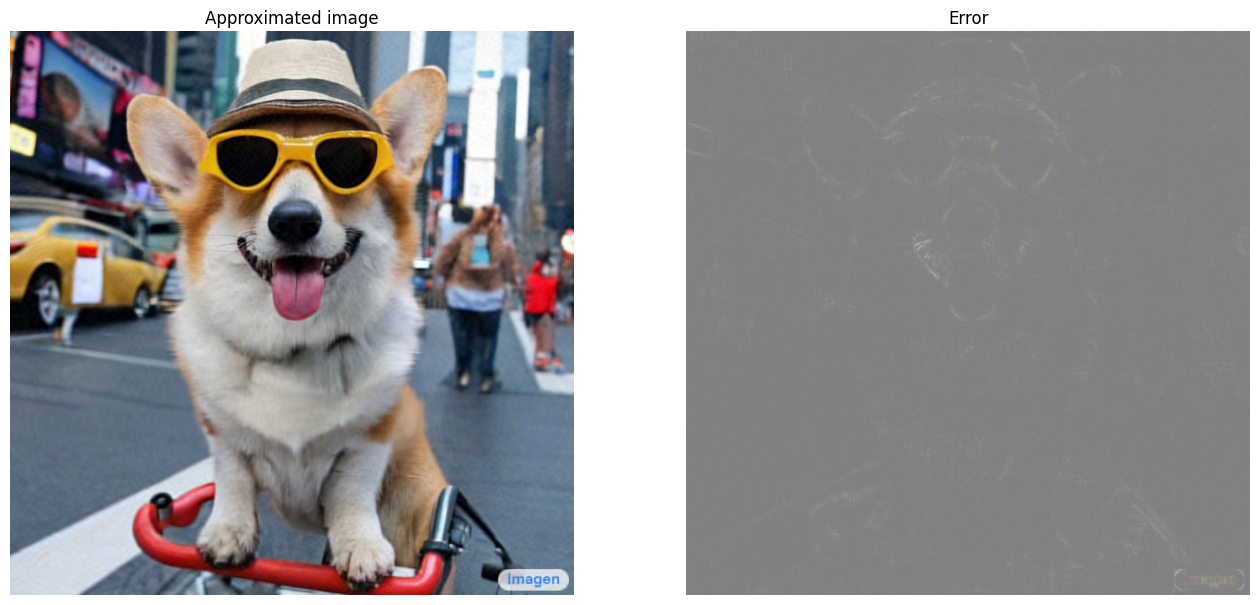

In [14]:
I_100, I_100_prop = compress_image(I, 100, verbose=True)

Original size of image: 3145728


Number of singular values used in compression: 50
Compressed image size: 307350
Proportion of original size: 0.098


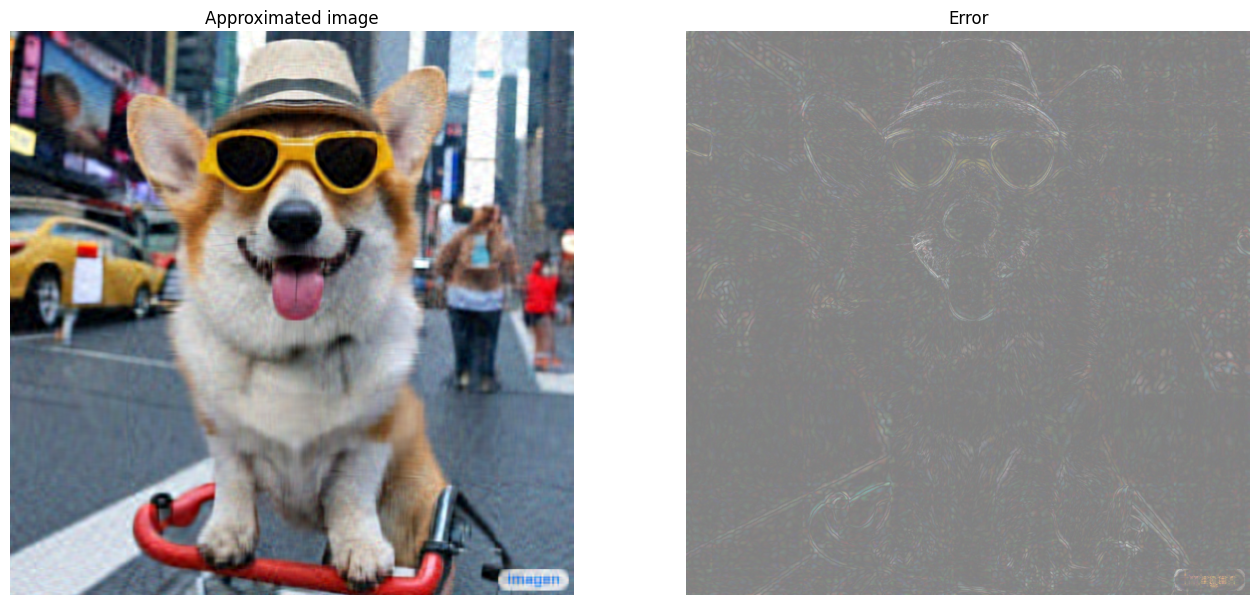

In [15]:
I_50, I_50_prop = compress_image(I, 50, verbose=True)

Original size of image: 3145728


Number of singular values used in compression: 10
Compressed image size: 61470
Proportion of original size: 0.020


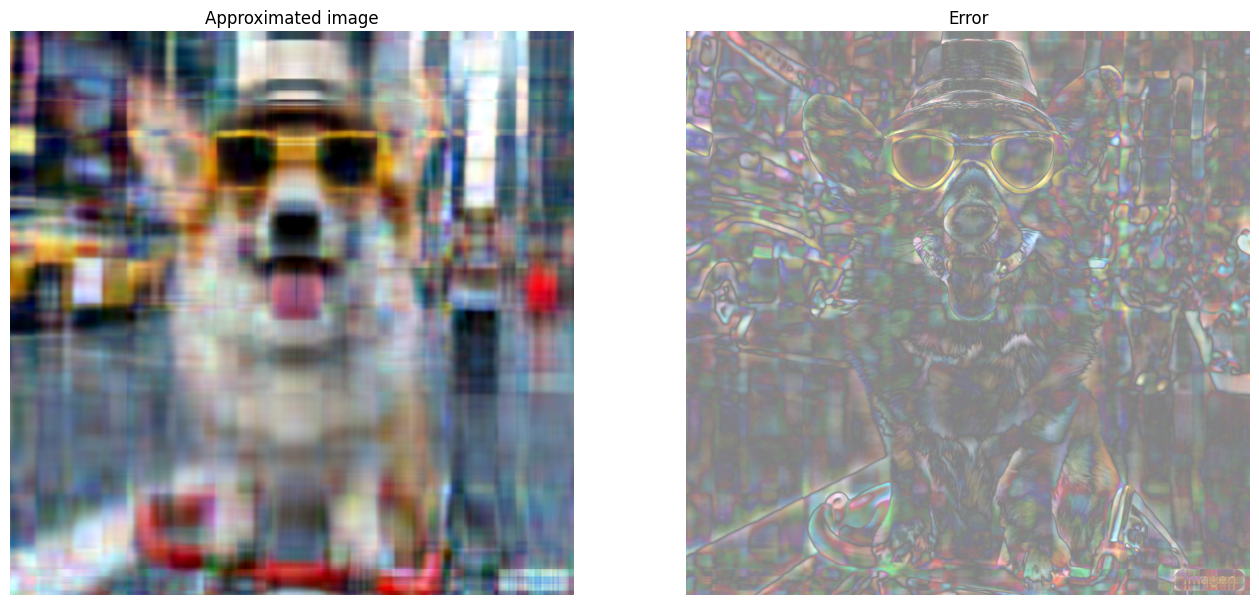

In [16]:
I_10, I_10_prop = compress_image(I, 10, verbose=True)

## Evaluating approximations

There are a variety of interesting methods to measure the effectiveness and have more control over matrix approximations.

### Compression factor vs rank

For each of the above approximations, observe how the data sizes change with the rank.

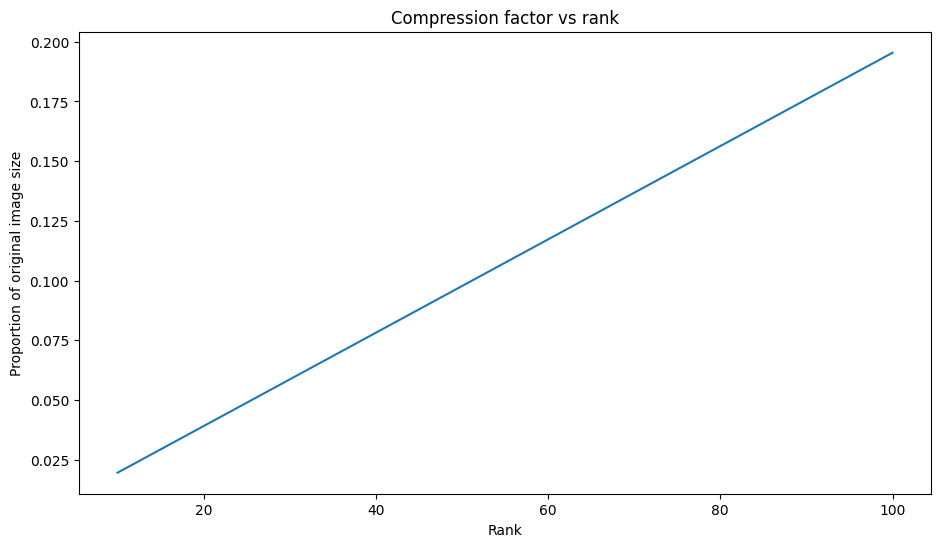

In [17]:
plt.figure(figsize=(11,6))
plt.plot([100, 50, 10], [I_100_prop, I_50_prop, I_10_prop])
plt.xlabel("Rank")
plt.ylabel("Proportion of original image size")
plt.title("Compression factor vs rank");

Based on this plot, there is a linear relationship between an approximated image's compression factor and its rank. To explore this further, recall that the data size of an approximated matrix, ${\mathrm{A}}_r$, is defined as the total number of elements required for its computation. The following equations can be used to find the relationship between compression factor and rank:

$$x = (m \times r) + r + (r \times n) = r \times (m + n + 1)$$

$$c = \large \frac{x}{y} = \frac{r \times (m + n + 1)}{m \times n}$$

where

* $x$: size of ${\mathrm{A_r}}$
* $y$: size of ${\mathrm{A}}$
* $c = \frac{x}{y}$: compression factor
* $r$: rank of the approximation
* $m$ and $n$: row and column dimensions of ${\mathrm{A}}$

In order to find the rank, $r$, that is necessary to compress an image to a desired factor, $c$, the above equation can be rearranged to solve for $r$:

$$r = ⌊{\large\frac{c \times m \times n}{m + n + 1}}⌋$$

Note that this formula is independent of the color channel dimension since each of the RGB approximations do not affect each other. Now, write a function to compress an input image given a desired compression factor.

In [18]:
def compress_image_with_factor(I, compression_factor, verbose=False):
  # Returns a compressed image based on a desired compression factor
  m,n,o = I.shape
  r = int((compression_factor * m * n)/(m + n + 1))
  I_r, I_r_prop = compress_image(I, r, verbose=verbose)
  return I_r

Compress an image to 15% of its original size.

Original size of image: 3145728


Number of singular values used in compression: 76
Compressed image size: 467172
Proportion of original size: 0.149


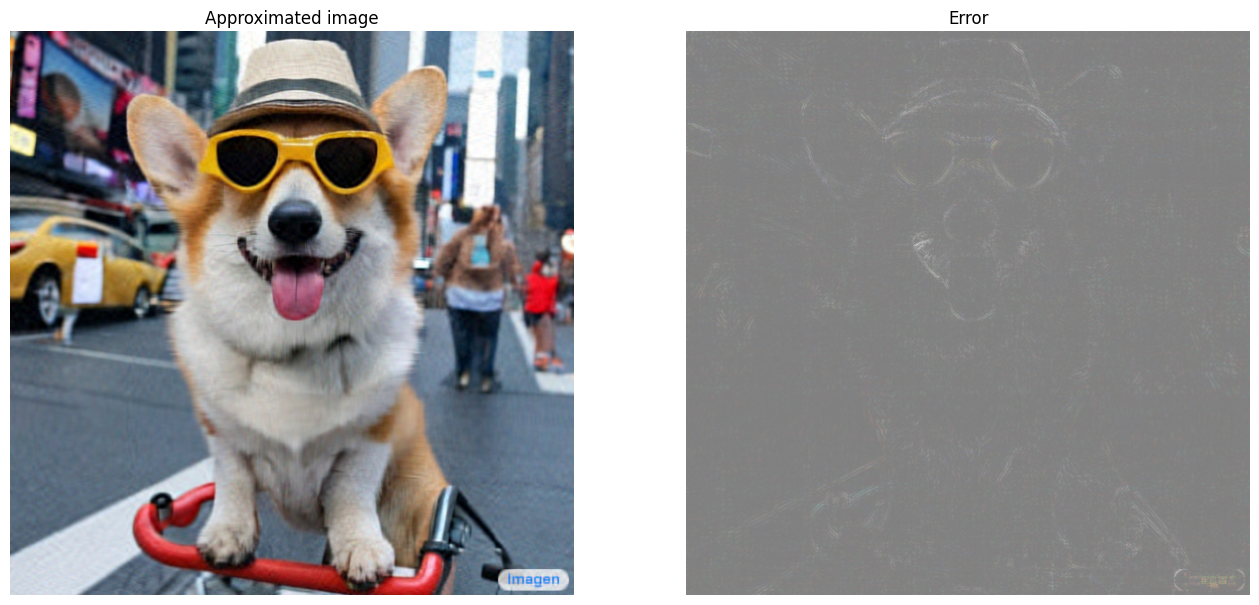

In [19]:
compression_factor = 0.15
I_r_img = compress_image_with_factor(I, compression_factor, verbose=True)

### Cumulative sum of singular values

The cumulative sum of singular values can be a useful indicator for the amount of energy captured by a rank-r approximation. Visualize the RGB-averaged cumulative proportion of singular values in the sample image. The `tf.cumsum` function can be useful for this.

In [20]:
def viz_energy(I):
  # Visualize the energy captured based on rank
  # Computing SVD
  I = tf.convert_to_tensor(I)/255
  I_batched = tf.transpose(I, [2, 0, 1]) 
  s, U, V = tf.linalg.svd(I_batched)
  # Plotting average proportion across RGB channels 
  props_rgb = tf.map_fn(lambda x: tf.cumsum(x)/tf.reduce_sum(x), s)
  props_rgb_mean = tf.reduce_mean(props_rgb, axis=0)
  plt.figure(figsize=(11,6))
  plt.plot(range(len(I)), props_rgb_mean, color='k')
  plt.xlabel("Rank / singular value number")
  plt.ylabel("Cumulative proportion of singular values")
  plt.title("RGB-averaged proportion of energy captured by the first 'r' singular values")

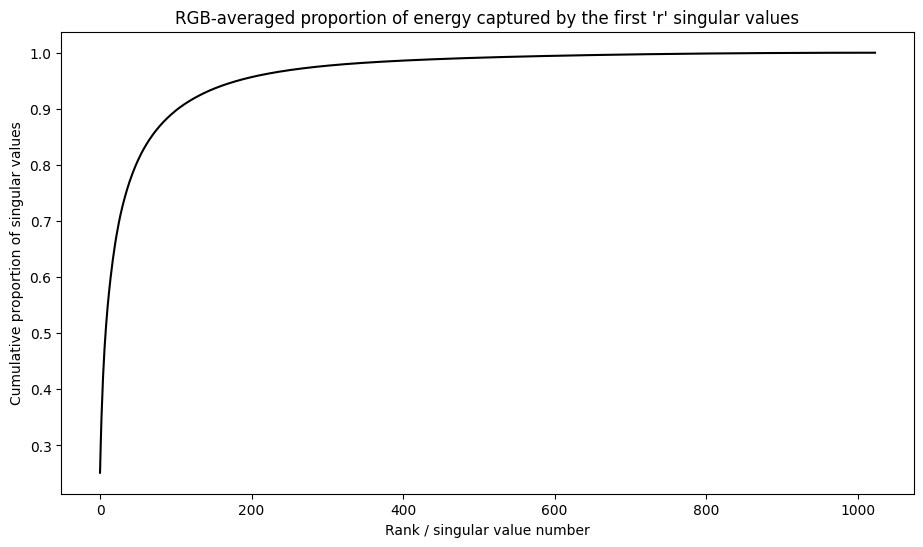

In [21]:
viz_energy(I)

It looks like over 90% of the energy in this image is captured within the first 100 singular values. Now, write a function to compress an input image given a desired energy retention factor.

In [22]:
def compress_image_with_energy(I, energy_factor, verbose=False):
  # Returns a compressed image based on a desired energy factor
  # Computing SVD
  I_rescaled = tf.convert_to_tensor(I)/255
  I_batched = tf.transpose(I_rescaled, [2, 0, 1]) 
  s, U, V = tf.linalg.svd(I_batched)
  # Extracting singular values
  props_rgb = tf.map_fn(lambda x: tf.cumsum(x)/tf.reduce_sum(x), s)
  props_rgb_mean = tf.reduce_mean(props_rgb, axis=0)
  # Find closest r that corresponds to the energy factor
  r = tf.argmin(tf.abs(props_rgb_mean - energy_factor)) + 1
  actual_ef = props_rgb_mean[r]
  I_r, I_r_prop = compress_image(I, r, verbose=verbose)
  print(f"Proportion of energy captured by the first {r} singular values: {actual_ef:.3f}")
  return I_r

Compress an image to retain 75% of its energy.

Original size of image: 3145728


Number of singular values used in compression: 35
Compressed image size: 215145
Proportion of original size: 0.068
Proportion of energy captured by the first 35 singular values: 0.753


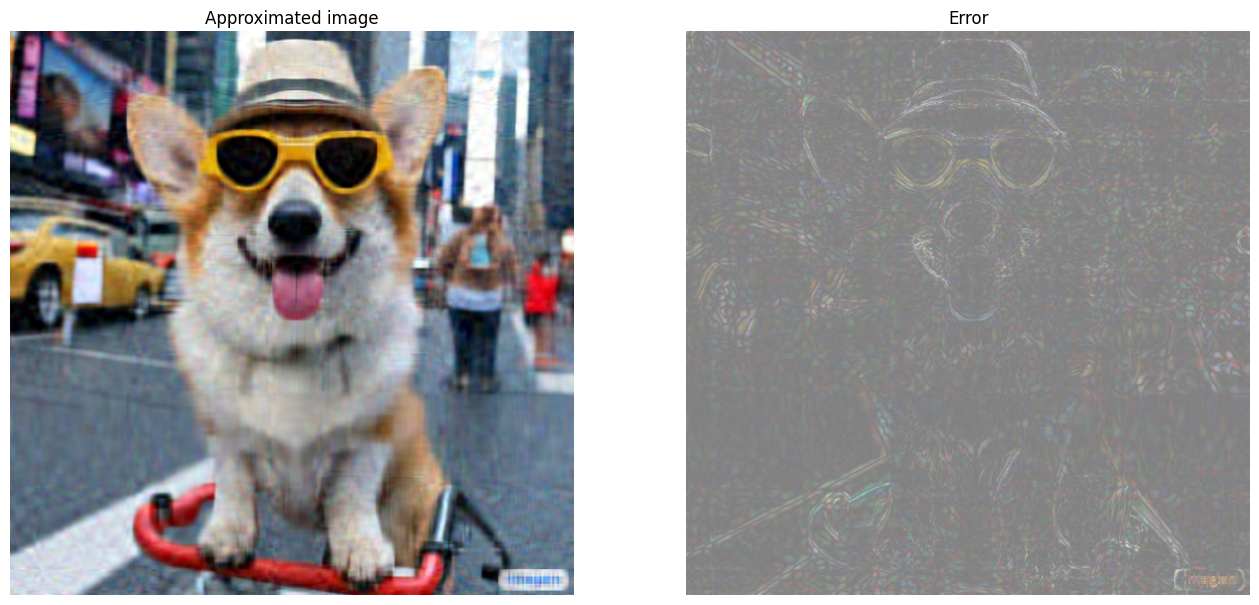

In [23]:
energy_factor = 0.75
I_r_img = compress_image_with_energy(I, energy_factor, verbose=True)

### Error and singular values

There is also an interesting relationship between the approximation error and the singular values. It turns out that the squared Frobenius norm of the approximation is equal to the sum of the squares of its singular values that were left out:

$${||A - A_r||}^2 = \sum_{i=r+1}^{R}σ_i^2$$

Test out this relationship with a rank-10 approximation of the example matrix in the beginning of this tutorial.

In [24]:
s, U, V = tf.linalg.svd(A)
A_10, A_10_size = rank_r_approx(s, U, V, 10)
squared_norm = tf.norm(A - A_10)**2
s_squared_sum = tf.reduce_sum(s[10:]**2)
print(f"Squared Frobenius norm: {squared_norm:.3f}")
print(f"Sum of squared singular values left out: {s_squared_sum:.3f}")

Squared Frobenius norm: 33.021
Sum of squared singular values left out: 33.021


## Conclusion

This notebook introduced the process of implementing the singular value decomposition with TensorFlow and applying it to write an image compression algorithm. Here are a few more tips that may help:

*   The [TensorFlow Core APIs](https://www.tensorflow.org/guide/core) can be utilized for a variety of high-performance scientific computing use cases.
*   To learn more about TensorFlow's linear algebra functionalities, visit the docs for the [linalg module](https://www.tensorflow.org/api_docs/python/tf/linalg).
*   The SVD can also be applied to build [recommendation systems](https://developers.google.com/machine-learning/recommendation/labs/movie-rec-programming-exercise).


For more examples of using the TensorFlow Core APIs, check out the [guide](https://www.tensorflow.org/guide/core). If you want learn more about loading and preparing data, see the tutorials on [image data loading](https://www.tensorflow.org/tutorials/load_data/images) or [CSV data loading](https://www.tensorflow.org/tutorials/load_data/csv).